In [1]:
import numpy as np
import pandas as pd
import scipy.signal as sg
from sklearn.preprocessing import StandardScaler
import random
import os
import pickle

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, utils, datasets  # %USERPROFILE%\.keras\datasets\
import matplotlib.pyplot as plt

In [9]:
address = r"IMU Dataset\Data"

optLen = 1054

learnRate = 1e-4
batchSize = 600
epoch = 200

sampleLen = 200
samplePerTrial = 5
features = 45
volunteers = 30
trainPortion = 0.8
valPortion = 0.1
testPortion = 0.1
classes = 5

trunk = 1
thighR = 2
thighL = 3
shankR = 4
shankL = 5
wrist = 6

norm = {'Acc_X': [-20.59292, 31.47302], 
        'Acc_Y': [-13.67152, 19.44969], 
        'Acc_Z': [-35.48537, 18.8095], 
        'Gyr_X': [-6.838557, 7.868352], 
        'Gyr_Y': [-16.90477, 16.61124], 
        'Gyr_Z': [-4.431263, 6.664771], 
        'Roll': [-207.2701, 214.6915], 
        'Pitch': [-89.953, 87.27671], 
        'Yaw': [-203.8373, 204.2526]}

In [3]:
def normalize_fixed(x, current_range, normed_range):
    current_min, current_max = current_range
    normed_min, normed_max = normed_range
    x_normed = (x - current_min) / (current_max - current_min)
    x_normed = x_normed * (normed_max - normed_min) + normed_min
    return x_normed

def trialLabel(num):
    if num in range(4, 10):
        return 0  # 'FE'
    if num in [16, 18, 20, 22, 24, 26]:
        return 1  # 'StrU'
    if num in [17, 19, 21, 23, 25, 27]:
        return 2  # 'StrD'
    if num in [28, 30, 32, 34, 36, 38]:
        return 3  # 'SlpU'
    if num in [29, 31, 33, 35, 37, 39]:
        return 4  # 'SlpD'
    print('Check dataset!')


def trialName(num):
    if num in range(4, 10):
        return 'FE: 0'
    if num in [16, 18, 20, 22, 24, 26]:
        return 'StrU: 1'
    if num in [17, 19, 21, 23, 25, 27]:
        return 'StrD: 2'
    if num in [28, 30, 32, 34, 36, 38]:
        return 'SlpU: 3'
    if num in [29, 31, 33, 35, 37, 39]:
        return 'SlpD: 4'
    return False


def trialInd(num):
    if num == 0:
        return 'FE: 0'
    if num == 1:
        return 'StrU: 1'
    if num == 2:
        return 'StrD: 2'
    if num == 3:
        return 'SlpU: 3'
    if num == 4:
        return 'SlpD: 4'
    return False


def openCSV(addr):
    df = pd.read_csv(addr, sep=',', header=None)
    header = df.iloc[0]
    df = pd.DataFrame(df[1:], dtype=float)
    df.columns = header
    return df

In [4]:
try:
    with open('data', 'rb') as f:
        data = pickle.load(f)
        
except:
    data = []
    for person in range(1, volunteers + 1):
        t = []
        print(person, "out of 30")
        for trial in range(1, 58):
            s = []
            for sensor in range(1, 7):
                s.append(openCSV(address + 'person{}_trial{}_sensor{}.csv'.format(person, trial, sensor)))
            t.append(s)
        data.append(t)

    with open('data', 'ab') as f:
        pickle.dump(data, f)

In [6]:
dic = {'Acc_X': [1e10, -1e10], 'Acc_Y': [1e10, -1e10], 'Acc_Z': [1e10, -1e10],
        'Gyr_X': [1e10, -1e10], 'Gyr_Y': [1e10, -1e10], 'Gyr_Z': [1e10, -1e10], 
        'Roll': [1e10, -1e10], 'Pitch': [1e10, -1e10], 'Yaw': [1e10, -1e10]}

for person in range(0, volunteers):
    for trial in list(range(3, 9)) + list(range(15, 39)):
        flag = False
        for i in range(samplePerTrial):
            for sample in range(i * sampleLen, sampleLen + i * sampleLen):
                for sensor in range(1, 5):
                    if flag:
                        break
                    if len(data[person][trial][sensor]) < optLen:
                        flag = True
                        continue
                    for para in ['Acc_X', 'Acc_Y', 'Acc_Z', 
                                'Gyr_X', 'Gyr_Y', 'Gyr_Z', 
                                'Roll', 'Pitch', 'Yaw']:
                        if data[person][trial][sensor][para].values[sample] > dic[para][1]:
                            dic[para][1] = data[person][trial][sensor][para].values[sample]
                        elif data[person][trial][sensor][para].values[sample] < dic[para][0]:
                            dic[para][0] = data[person][trial][sensor][para].values[sample]

print(dic)

{'Acc_X': [-20.59292, 31.47302], 'Acc_Y': [-13.67152, 19.44969], 'Acc_Z': [-35.48537, 18.8095], 'Gyr_X': [-6.838557, 7.868352], 'Gyr_Y': [-16.90477, 16.61124], 'Gyr_Z': [-4.431263, 6.664771], 'Roll': [-207.2701, 214.6915], 'Pitch': [-89.953, 87.27671], 'Yaw': [-203.8373, 204.2526]}


In [5]:
ds = []
dsr = []
dsLbl = []
headers = []

for s in ('TR_', 'TL_', 'SR_', 'SL_'):
    for h in [f'{s}Acc_X', f'{s}Acc_Y', f'{s}Gyr_Y', f'{s}Gyr_Z', f'{s}Roll']:
        headers.append(h)

for person in range(0, volunteers):
    for trial in list(range(3, 9)) + list(range(15, 39)):
        flag = False
        for i in range(samplePerTrial):
            tmp = []
            tmpr = []
            for sample in range(i * sampleLen, sampleLen + i * sampleLen):
                tmp2 = []
                tmpr2 = []
                # tmp2.append(np.sin(np.pi * sample/42))
                for sensor in range(0, 5):
                    if flag:
                        break
                    if len(data[person][trial][sensor]) < optLen:
                        flag = True
                        continue
                    for para in ['Acc_X', 'Acc_Y', 'Acc_Z', 
                                'Gyr_X', 'Gyr_Y', 'Gyr_Z', 
                                'Roll', 'Pitch', 'Yaw']:
                        rawData = data[person][trial][sensor][para].values[sample]
                        if not np.isfinite(rawData):
                            rawData = 0
                        normData = normalize_fixed(rawData, norm[para], [-1, 1])
                        tmp2.append(normData)
                        tmpr2.append(rawData)
                if flag:
                    break
                tmp.append(tmp2)
                tmpr.append(tmpr2)
            if flag:
                break
            ds.append(tmp)
            dsr.append(tmpr)
            dsLbl.append(int(trialLabel(trial + 1)))
            
print(len(ds))

4270


In [6]:
ds2 = tf.convert_to_tensor(ds,  dtype='float64')
dsLbl2 = tf.one_hot(dsLbl, classes)
print(ds2.shape, dsLbl2.shape)

(4270, 200, 45) (4270, 5)


Epoch 1/200
53/53 [==============================] - 1s 13ms/step - loss: 1.7253 - accuracy: 0.3084 - val_loss: 1.5979 - val_accuracy: 0.2931
Epoch 2/200
53/53 [==============================] - 0s 9ms/step - loss: 1.4473 - accuracy: 0.3793 - val_loss: 1.5799 - val_accuracy: 0.3448
Epoch 3/200
53/53 [==============================] - 0s 6ms/step - loss: 1.2678 - accuracy: 0.4885 - val_loss: 1.5594 - val_accuracy: 0.4483
Epoch 4/200
53/53 [==============================] - 0s 6ms/step - loss: 1.0935 - accuracy: 0.5824 - val_loss: 1.5425 - val_accuracy: 0.4655
Epoch 5/200
53/53 [==============================] - 0s 6ms/step - loss: 1.0398 - accuracy: 0.6130 - val_loss: 1.5191 - val_accuracy: 0.5000
Epoch 6/200
53/53 [==============================] - 0s 6ms/step - loss: 0.8829 - accuracy: 0.6820 - val_loss: 1.4902 - val_accuracy: 0.4483
Epoch 7/200
53/53 [==============================] - 0s 5ms/step - loss: 0.8308 - accuracy: 0.6954 - val_loss: 1.4588 - val_accuracy: 0.4655
Epoch 8/200


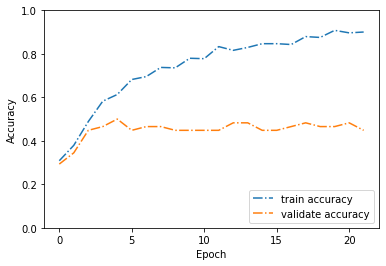

Epoch 1/200
53/53 [==============================] - 1s 20ms/step - loss: 1.5011 - accuracy: 0.3429 - val_loss: 1.6533 - val_accuracy: 0.0690
Epoch 2/200
53/53 [==============================] - 1s 10ms/step - loss: 1.2527 - accuracy: 0.5785 - val_loss: 1.6002 - val_accuracy: 0.1207
Epoch 3/200
53/53 [==============================] - 0s 9ms/step - loss: 1.0303 - accuracy: 0.7165 - val_loss: 1.5927 - val_accuracy: 0.1552
Epoch 4/200
53/53 [==============================] - 1s 10ms/step - loss: 0.8573 - accuracy: 0.7644 - val_loss: 1.6046 - val_accuracy: 0.1552
Epoch 5/200
53/53 [==============================] - 0s 9ms/step - loss: 0.7054 - accuracy: 0.8046 - val_loss: 1.5285 - val_accuracy: 0.3621
Epoch 6/200
53/53 [==============================] - 0s 9ms/step - loss: 0.6010 - accuracy: 0.8391 - val_loss: 1.4837 - val_accuracy: 0.3966
Epoch 7/200
53/53 [==============================] - 0s 9ms/step - loss: 0.5014 - accuracy: 0.8602 - val_loss: 1.5425 - val_accuracy: 0.3448
Epoch 8/20

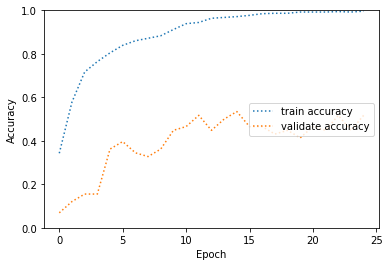

Epoch 1/200
47/47 [==============================] - 1s 13ms/step - loss: 1.7337 - accuracy: 0.2851 - val_loss: 1.6099 - val_accuracy: 0.0962
Epoch 2/200
47/47 [==============================] - 0s 6ms/step - loss: 1.3695 - accuracy: 0.4574 - val_loss: 1.5884 - val_accuracy: 0.1923
Epoch 3/200
47/47 [==============================] - 0s 5ms/step - loss: 1.2232 - accuracy: 0.5128 - val_loss: 1.5621 - val_accuracy: 0.2692
Epoch 4/200
47/47 [==============================] - 0s 5ms/step - loss: 1.1148 - accuracy: 0.5660 - val_loss: 1.5351 - val_accuracy: 0.3077
Epoch 5/200
47/47 [==============================] - 0s 5ms/step - loss: 1.0049 - accuracy: 0.6298 - val_loss: 1.4903 - val_accuracy: 0.4038
Epoch 6/200
47/47 [==============================] - 0s 5ms/step - loss: 0.9219 - accuracy: 0.6468 - val_loss: 1.4562 - val_accuracy: 0.4615
Epoch 7/200
47/47 [==============================] - 0s 5ms/step - loss: 0.8222 - accuracy: 0.7064 - val_loss: 1.4123 - val_accuracy: 0.5192
Epoch 8/200


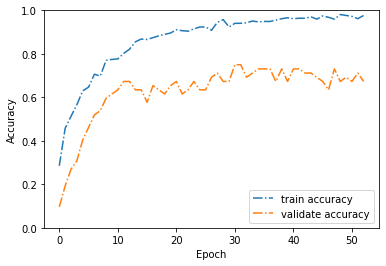

Epoch 1/200
47/47 [==============================] - 1s 22ms/step - loss: 1.5531 - accuracy: 0.2894 - val_loss: 1.6182 - val_accuracy: 0.2692
Epoch 2/200
47/47 [==============================] - 0s 10ms/step - loss: 1.2905 - accuracy: 0.6000 - val_loss: 1.6364 - val_accuracy: 0.1731
Epoch 3/200
47/47 [==============================] - 0s 8ms/step - loss: 1.0664 - accuracy: 0.6745 - val_loss: 1.6465 - val_accuracy: 0.2692
Epoch 4/200
47/47 [==============================] - 0s 8ms/step - loss: 0.8684 - accuracy: 0.7638 - val_loss: 1.5712 - val_accuracy: 0.2692
Epoch 5/200
47/47 [==============================] - 0s 9ms/step - loss: 0.6928 - accuracy: 0.8191 - val_loss: 1.5660 - val_accuracy: 0.3077
Epoch 6/200
47/47 [==============================] - 0s 9ms/step - loss: 0.5558 - accuracy: 0.8511 - val_loss: 1.5369 - val_accuracy: 0.3654
Epoch 7/200
47/47 [==============================] - 0s 9ms/step - loss: 0.4459 - accuracy: 0.8851 - val_loss: 1.5413 - val_accuracy: 0.3462
Epoch 8/200

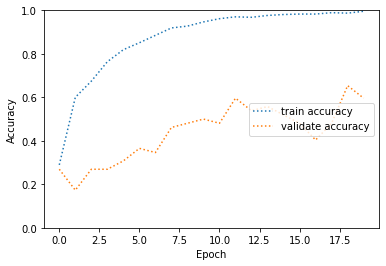

Epoch 1/200
43/43 [==============================] - 1s 12ms/step - loss: 1.8929 - accuracy: 0.2530 - val_loss: 1.6179 - val_accuracy: 0.3617
Epoch 2/200
43/43 [==============================] - 0s 8ms/step - loss: 1.6499 - accuracy: 0.3215 - val_loss: 1.6051 - val_accuracy: 0.2340
Epoch 3/200
43/43 [==============================] - 0s 5ms/step - loss: 1.3842 - accuracy: 0.4468 - val_loss: 1.5990 - val_accuracy: 0.3617
Epoch 4/200
43/43 [==============================] - 0s 6ms/step - loss: 1.2066 - accuracy: 0.5106 - val_loss: 1.5854 - val_accuracy: 0.4043
Epoch 5/200
43/43 [==============================] - 0s 5ms/step - loss: 1.1147 - accuracy: 0.5603 - val_loss: 1.5727 - val_accuracy: 0.3617
Epoch 6/200
43/43 [==============================] - 0s 5ms/step - loss: 1.0136 - accuracy: 0.6359 - val_loss: 1.5484 - val_accuracy: 0.3617
Epoch 7/200
43/43 [==============================] - 0s 5ms/step - loss: 0.9715 - accuracy: 0.5887 - val_loss: 1.5223 - val_accuracy: 0.4255
Epoch 8/200


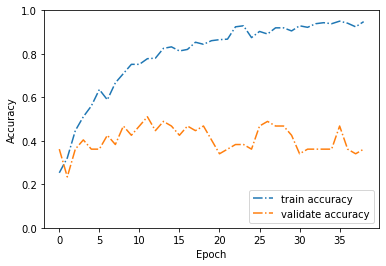

Epoch 1/200
43/43 [==============================] - 1s 24ms/step - loss: 1.5017 - accuracy: 0.3712 - val_loss: 1.4714 - val_accuracy: 0.3404
Epoch 2/200
43/43 [==============================] - 0s 10ms/step - loss: 1.2483 - accuracy: 0.5887 - val_loss: 1.3611 - val_accuracy: 0.2979
Epoch 3/200
43/43 [==============================] - 0s 9ms/step - loss: 1.0153 - accuracy: 0.7329 - val_loss: 1.2801 - val_accuracy: 0.4043
Epoch 4/200
43/43 [==============================] - 0s 9ms/step - loss: 0.8132 - accuracy: 0.7589 - val_loss: 1.2901 - val_accuracy: 0.4894
Epoch 5/200
43/43 [==============================] - 0s 9ms/step - loss: 0.6517 - accuracy: 0.8227 - val_loss: 1.2742 - val_accuracy: 0.5319
Epoch 6/200
43/43 [==============================] - 0s 9ms/step - loss: 0.5157 - accuracy: 0.8629 - val_loss: 1.3414 - val_accuracy: 0.4894
Epoch 7/200
43/43 [==============================] - 0s 9ms/step - loss: 0.4208 - accuracy: 0.8747 - val_loss: 1.4622 - val_accuracy: 0.4255
Epoch 8/200

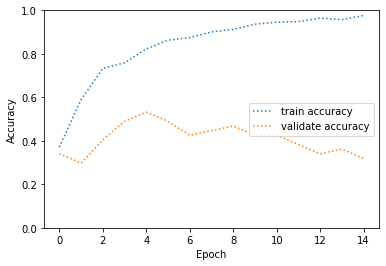

Epoch 1/200
39/39 [==============================] - 1s 13ms/step - loss: 1.9831 - accuracy: 0.2336 - val_loss: 1.5888 - val_accuracy: 0.1905
Epoch 2/200
39/39 [==============================] - 0s 8ms/step - loss: 1.6499 - accuracy: 0.3360 - val_loss: 1.5607 - val_accuracy: 0.2857
Epoch 3/200
39/39 [==============================] - 0s 6ms/step - loss: 1.4271 - accuracy: 0.4173 - val_loss: 1.5412 - val_accuracy: 0.3333
Epoch 4/200
39/39 [==============================] - 0s 6ms/step - loss: 1.1458 - accuracy: 0.5722 - val_loss: 1.5064 - val_accuracy: 0.5000
Epoch 5/200
39/39 [==============================] - 0s 7ms/step - loss: 1.0671 - accuracy: 0.5984 - val_loss: 1.4717 - val_accuracy: 0.5714
Epoch 6/200
39/39 [==============================] - 0s 5ms/step - loss: 0.9942 - accuracy: 0.5801 - val_loss: 1.4161 - val_accuracy: 0.7381
Epoch 7/200
39/39 [==============================] - 0s 5ms/step - loss: 0.9414 - accuracy: 0.6352 - val_loss: 1.3540 - val_accuracy: 0.7381
Epoch 8/200


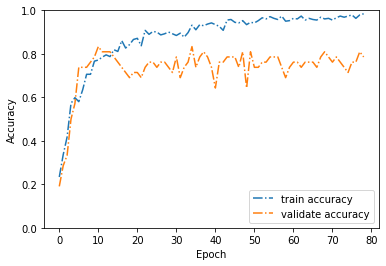

Epoch 1/200
39/39 [==============================] - 1s 23ms/step - loss: 1.5325 - accuracy: 0.3386 - val_loss: 1.6774 - val_accuracy: 0.1667
Epoch 2/200
39/39 [==============================] - 0s 11ms/step - loss: 1.3086 - accuracy: 0.5932 - val_loss: 1.6047 - val_accuracy: 0.1905
Epoch 3/200
39/39 [==============================] - 0s 10ms/step - loss: 1.1022 - accuracy: 0.7192 - val_loss: 1.5213 - val_accuracy: 0.2381
Epoch 4/200
39/39 [==============================] - 0s 9ms/step - loss: 0.9290 - accuracy: 0.7428 - val_loss: 1.5015 - val_accuracy: 0.2619
Epoch 5/200
39/39 [==============================] - 0s 9ms/step - loss: 0.7752 - accuracy: 0.7927 - val_loss: 1.4587 - val_accuracy: 0.2857
Epoch 6/200
39/39 [==============================] - 0s 10ms/step - loss: 0.6399 - accuracy: 0.8163 - val_loss: 1.3915 - val_accuracy: 0.3095
Epoch 7/200
39/39 [==============================] - 0s 9ms/step - loss: 0.5413 - accuracy: 0.8451 - val_loss: 1.3710 - val_accuracy: 0.3810
Epoch 8/2

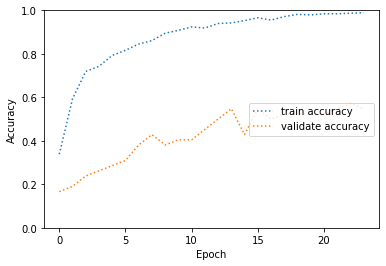

Epoch 1/200
35/35 [==============================] - 0s 14ms/step - loss: 1.8423 - accuracy: 0.2507 - val_loss: 1.6139 - val_accuracy: 0.1316
Epoch 2/200
35/35 [==============================] - 0s 9ms/step - loss: 1.6161 - accuracy: 0.3236 - val_loss: 1.6064 - val_accuracy: 0.1842
Epoch 3/200
35/35 [==============================] - 0s 6ms/step - loss: 1.3951 - accuracy: 0.4461 - val_loss: 1.5959 - val_accuracy: 0.2895
Epoch 4/200
35/35 [==============================] - 0s 6ms/step - loss: 1.2271 - accuracy: 0.5219 - val_loss: 1.5862 - val_accuracy: 0.3947
Epoch 5/200
35/35 [==============================] - 0s 6ms/step - loss: 1.1354 - accuracy: 0.5714 - val_loss: 1.5767 - val_accuracy: 0.4211
Epoch 6/200
35/35 [==============================] - 0s 6ms/step - loss: 1.0172 - accuracy: 0.6239 - val_loss: 1.5692 - val_accuracy: 0.3684
Epoch 7/200
35/35 [==============================] - 0s 5ms/step - loss: 0.9442 - accuracy: 0.6239 - val_loss: 1.5589 - val_accuracy: 0.3158
Epoch 8/200


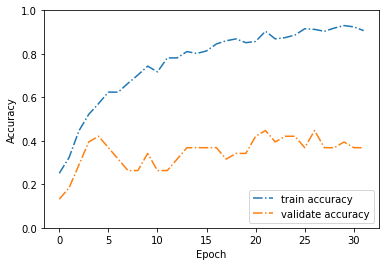

Epoch 1/200
35/35 [==============================] - 1s 26ms/step - loss: 1.4786 - accuracy: 0.3499 - val_loss: 1.6531 - val_accuracy: 0.1579
Epoch 2/200
35/35 [==============================] - 0s 10ms/step - loss: 1.2497 - accuracy: 0.6093 - val_loss: 1.4591 - val_accuracy: 0.3684
Epoch 3/200
35/35 [==============================] - 0s 9ms/step - loss: 1.0554 - accuracy: 0.7376 - val_loss: 1.4598 - val_accuracy: 0.2632
Epoch 4/200
35/35 [==============================] - 0s 10ms/step - loss: 0.8877 - accuracy: 0.7813 - val_loss: 1.3809 - val_accuracy: 0.2632
Epoch 5/200
35/35 [==============================] - 0s 10ms/step - loss: 0.7526 - accuracy: 0.8163 - val_loss: 1.3815 - val_accuracy: 0.2632
Epoch 6/200
35/35 [==============================] - 0s 9ms/step - loss: 0.6363 - accuracy: 0.8397 - val_loss: 1.3089 - val_accuracy: 0.3684
Epoch 7/200
35/35 [==============================] - 0s 10ms/step - loss: 0.5384 - accuracy: 0.8659 - val_loss: 1.4257 - val_accuracy: 0.3158
Epoch 8/

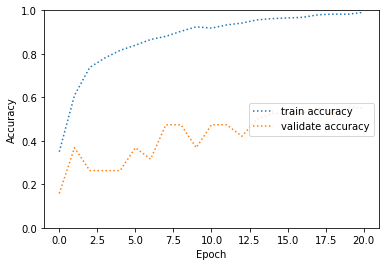

Epoch 1/200
31/31 [==============================] - 1s 18ms/step - loss: 1.7826 - accuracy: 0.2816 - val_loss: 1.5760 - val_accuracy: 0.2941
Epoch 2/200
31/31 [==============================] - 0s 8ms/step - loss: 1.5648 - accuracy: 0.3560 - val_loss: 1.5789 - val_accuracy: 0.3529
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 1.3602 - accuracy: 0.4531 - val_loss: 1.5816 - val_accuracy: 0.4118
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 1.1999 - accuracy: 0.5372 - val_loss: 1.5815 - val_accuracy: 0.4118
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 1.0789 - accuracy: 0.5987 - val_loss: 1.5752 - val_accuracy: 0.3529
Epoch 6/200
31/31 [==============================] - 0s 6ms/step - loss: 1.0293 - accuracy: 0.6181 - val_loss: 1.5682 - val_accuracy: 0.3529
Epoch 7/200
31/31 [==============================] - 0s 6ms/step - loss: 0.9402 - accuracy: 0.6278 - val_loss: 1.5642 - val_accuracy: 0.3529
Epoch 8/200


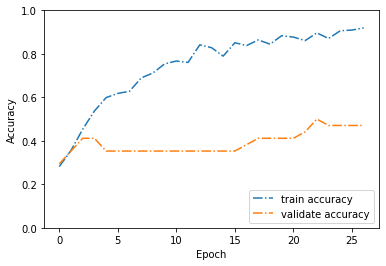

Epoch 1/200
31/31 [==============================] - 1s 28ms/step - loss: 1.5204 - accuracy: 0.3560 - val_loss: 1.6193 - val_accuracy: 0.2941
Epoch 2/200
31/31 [==============================] - 0s 11ms/step - loss: 1.2712 - accuracy: 0.6570 - val_loss: 1.7942 - val_accuracy: 0.2059
Epoch 3/200
31/31 [==============================] - 0s 10ms/step - loss: 1.0708 - accuracy: 0.7476 - val_loss: 1.7387 - val_accuracy: 0.2647
Epoch 4/200
31/31 [==============================] - 0s 11ms/step - loss: 0.8949 - accuracy: 0.7896 - val_loss: 1.8577 - val_accuracy: 0.2059
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.7584 - accuracy: 0.7929 - val_loss: 1.8149 - val_accuracy: 0.2353
Epoch 6/200
31/31 [==============================] - 0s 9ms/step - loss: 0.6515 - accuracy: 0.8479 - val_loss: 1.8359 - val_accuracy: 0.3235
Epoch 7/200
31/31 [==============================] - 0s 9ms/step - loss: 0.5629 - accuracy: 0.8738 - val_loss: 1.9137 - val_accuracy: 0.3235
Epoch 8/2

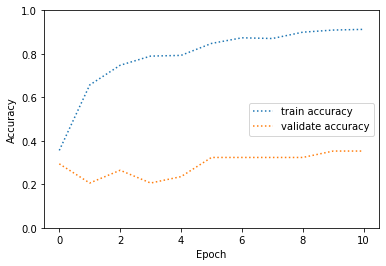

Epoch 1/200
28/28 [==============================] - 0s 17ms/step - loss: 1.9076 - accuracy: 0.2043 - val_loss: 1.6213 - val_accuracy: 0.0667
Epoch 2/200
28/28 [==============================] - 0s 11ms/step - loss: 1.4969 - accuracy: 0.3943 - val_loss: 1.6279 - val_accuracy: 0.0000e+00
Epoch 3/200
28/28 [==============================] - 0s 6ms/step - loss: 1.2943 - accuracy: 0.5018 - val_loss: 1.6281 - val_accuracy: 0.0000e+00
Epoch 4/200
28/28 [==============================] - 0s 6ms/step - loss: 1.1716 - accuracy: 0.5520 - val_loss: 1.6211 - val_accuracy: 0.0000e+00
Epoch 5/200
28/28 [==============================] - 0s 5ms/step - loss: 1.0271 - accuracy: 0.6057 - val_loss: 1.6194 - val_accuracy: 0.0000e+00
Epoch 6/200
28/28 [==============================] - 0s 5ms/step - loss: 0.9425 - accuracy: 0.6774 - val_loss: 1.6099 - val_accuracy: 0.0333
Epoch 7/200
28/28 [==============================] - 0s 6ms/step - loss: 0.8659 - accuracy: 0.7276 - val_loss: 1.5964 - val_accuracy: 0.

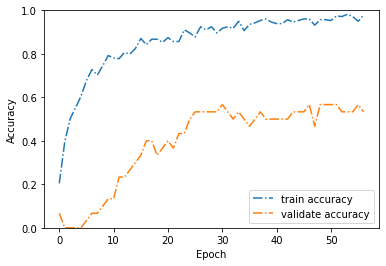

Epoch 1/200
28/28 [==============================] - 1s 31ms/step - loss: 1.5825 - accuracy: 0.2724 - val_loss: 1.7848 - val_accuracy: 0.0333
Epoch 2/200
28/28 [==============================] - 0s 13ms/step - loss: 1.3446 - accuracy: 0.5699 - val_loss: 1.7687 - val_accuracy: 0.0333
Epoch 3/200
28/28 [==============================] - 0s 9ms/step - loss: 1.1458 - accuracy: 0.7455 - val_loss: 1.8056 - val_accuracy: 0.0333
Epoch 4/200
28/28 [==============================] - 0s 9ms/step - loss: 0.9768 - accuracy: 0.8065 - val_loss: 1.9370 - val_accuracy: 0.0333
Epoch 5/200
28/28 [==============================] - 0s 9ms/step - loss: 0.8269 - accuracy: 0.8065 - val_loss: 1.9534 - val_accuracy: 0.0333
Epoch 6/200
28/28 [==============================] - 0s 9ms/step - loss: 0.7060 - accuracy: 0.8387 - val_loss: 2.0440 - val_accuracy: 0.0333
Epoch 7/200
28/28 [==============================] - 0s 9ms/step - loss: 0.5970 - accuracy: 0.8566 - val_loss: 2.0497 - val_accuracy: 0.0333
Epoch 8/200

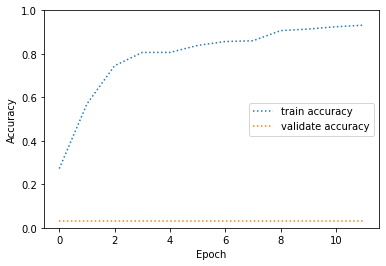

Epoch 1/200
26/26 [==============================] - 0s 18ms/step - loss: 1.9548 - accuracy: 0.2222 - val_loss: 1.6072 - val_accuracy: 0.2222
Epoch 2/200
26/26 [==============================] - 0s 11ms/step - loss: 1.6641 - accuracy: 0.2976 - val_loss: 1.6201 - val_accuracy: 0.1852
Epoch 3/200
26/26 [==============================] - 0s 5ms/step - loss: 1.4740 - accuracy: 0.4008 - val_loss: 1.6253 - val_accuracy: 0.1852
Epoch 4/200
26/26 [==============================] - 0s 6ms/step - loss: 1.2443 - accuracy: 0.4603 - val_loss: 1.6231 - val_accuracy: 0.1852
Epoch 5/200
26/26 [==============================] - 0s 6ms/step - loss: 1.2411 - accuracy: 0.5198 - val_loss: 1.6170 - val_accuracy: 0.1852
Epoch 6/200
26/26 [==============================] - 0s 6ms/step - loss: 1.0533 - accuracy: 0.6151 - val_loss: 1.6197 - val_accuracy: 0.1481
Epoch 7/200
26/26 [==============================] - 0s 6ms/step - loss: 0.9740 - accuracy: 0.6389 - val_loss: 1.6146 - val_accuracy: 0.1481
Epoch 8/200

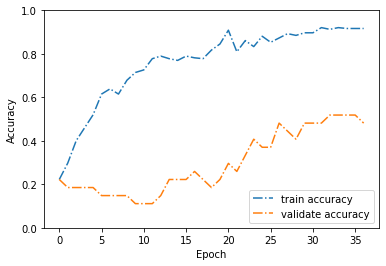

Epoch 1/200
26/26 [==============================] - 1s 34ms/step - loss: 1.5553 - accuracy: 0.3333 - val_loss: 1.7753 - val_accuracy: 0.0000e+00
Epoch 2/200
26/26 [==============================] - 0s 14ms/step - loss: 1.3478 - accuracy: 0.5516 - val_loss: 1.6254 - val_accuracy: 0.1111
Epoch 3/200
26/26 [==============================] - 0s 9ms/step - loss: 1.1774 - accuracy: 0.6865 - val_loss: 1.6159 - val_accuracy: 0.1852
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 1.0324 - accuracy: 0.7063 - val_loss: 1.5613 - val_accuracy: 0.1481
Epoch 5/200
26/26 [==============================] - 0s 10ms/step - loss: 0.9018 - accuracy: 0.7619 - val_loss: 1.4362 - val_accuracy: 0.3704
Epoch 6/200
26/26 [==============================] - 0s 9ms/step - loss: 0.7838 - accuracy: 0.8135 - val_loss: 1.4309 - val_accuracy: 0.3704
Epoch 7/200
26/26 [==============================] - 0s 9ms/step - loss: 0.6764 - accuracy: 0.8413 - val_loss: 1.4171 - val_accuracy: 0.3704
Epoch 

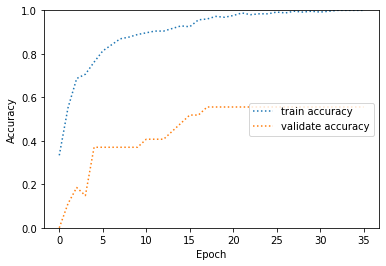

Epoch 1/200
23/23 [==============================] - 0s 21ms/step - loss: 2.0019 - accuracy: 0.1938 - val_loss: 1.6208 - val_accuracy: 0.1200
Epoch 2/200
23/23 [==============================] - 0s 7ms/step - loss: 1.7816 - accuracy: 0.2731 - val_loss: 1.6341 - val_accuracy: 0.1200
Epoch 3/200
23/23 [==============================] - 0s 7ms/step - loss: 1.4832 - accuracy: 0.4141 - val_loss: 1.6482 - val_accuracy: 0.0400
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 1.3611 - accuracy: 0.4229 - val_loss: 1.6572 - val_accuracy: 0.0000e+00
Epoch 5/200
23/23 [==============================] - 0s 6ms/step - loss: 1.2852 - accuracy: 0.4758 - val_loss: 1.6693 - val_accuracy: 0.0000e+00
Epoch 6/200
23/23 [==============================] - 0s 6ms/step - loss: 1.1675 - accuracy: 0.5374 - val_loss: 1.6807 - val_accuracy: 0.0000e+00
Epoch 7/200
23/23 [==============================] - 0s 6ms/step - loss: 1.1405 - accuracy: 0.5242 - val_loss: 1.6913 - val_accuracy: 0.0000e

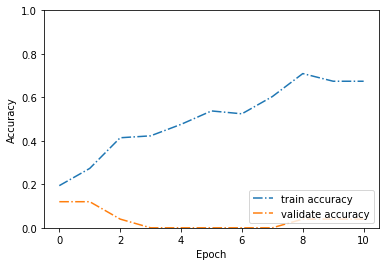

Epoch 1/200
23/23 [==============================] - 5s 199ms/step - loss: 1.5266 - accuracy: 0.3128 - val_loss: 1.8539 - val_accuracy: 0.0400
Epoch 2/200
23/23 [==============================] - 0s 14ms/step - loss: 1.3347 - accuracy: 0.5507 - val_loss: 1.7355 - val_accuracy: 0.0800
Epoch 3/200
23/23 [==============================] - 0s 10ms/step - loss: 1.1684 - accuracy: 0.6476 - val_loss: 1.7872 - val_accuracy: 0.0800
Epoch 4/200
23/23 [==============================] - 0s 10ms/step - loss: 1.0026 - accuracy: 0.7621 - val_loss: 1.7971 - val_accuracy: 0.0400
Epoch 5/200
23/23 [==============================] - 0s 11ms/step - loss: 0.8653 - accuracy: 0.7974 - val_loss: 1.8171 - val_accuracy: 0.0800
Epoch 6/200
23/23 [==============================] - 0s 9ms/step - loss: 0.7331 - accuracy: 0.8194 - val_loss: 1.8610 - val_accuracy: 0.1600
Epoch 7/200
23/23 [==============================] - 0s 10ms/step - loss: 0.6294 - accuracy: 0.8370 - val_loss: 1.8929 - val_accuracy: 0.2000
Epoch 

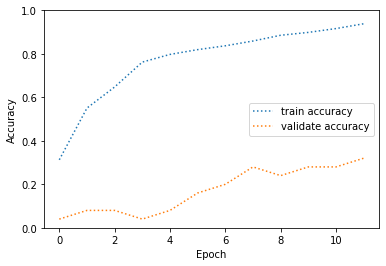

Epoch 1/200
21/21 [==============================] - 0s 24ms/step - loss: 1.8781 - accuracy: 0.2049 - val_loss: 1.6143 - val_accuracy: 0.1364
Epoch 2/200
21/21 [==============================] - 0s 15ms/step - loss: 1.7153 - accuracy: 0.2976 - val_loss: 1.6236 - val_accuracy: 0.0455
Epoch 3/200
21/21 [==============================] - 0s 7ms/step - loss: 1.5295 - accuracy: 0.3610 - val_loss: 1.6311 - val_accuracy: 0.0909
Epoch 4/200
21/21 [==============================] - 0s 7ms/step - loss: 1.4514 - accuracy: 0.4195 - val_loss: 1.6364 - val_accuracy: 0.0455
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 1.3002 - accuracy: 0.4732 - val_loss: 1.6395 - val_accuracy: 0.0455
Epoch 6/200
21/21 [==============================] - 0s 7ms/step - loss: 1.2644 - accuracy: 0.4683 - val_loss: 1.6413 - val_accuracy: 0.0455
Epoch 7/200
21/21 [==============================] - 0s 7ms/step - loss: 1.1893 - accuracy: 0.5122 - val_loss: 1.6405 - val_accuracy: 0.0909
Epoch 8/200

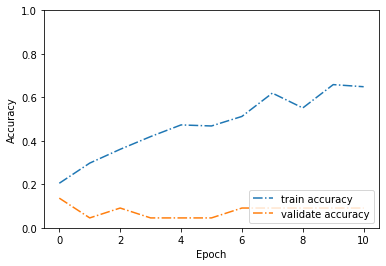

Epoch 1/200
21/21 [==============================] - 1s 35ms/step - loss: 1.6408 - accuracy: 0.2146 - val_loss: 1.6719 - val_accuracy: 0.1364
Epoch 2/200
21/21 [==============================] - 0s 11ms/step - loss: 1.4816 - accuracy: 0.4146 - val_loss: 1.5705 - val_accuracy: 0.1364
Epoch 3/200
21/21 [==============================] - 0s 10ms/step - loss: 1.3326 - accuracy: 0.5902 - val_loss: 1.5661 - val_accuracy: 0.1364
Epoch 4/200
21/21 [==============================] - 0s 10ms/step - loss: 1.2133 - accuracy: 0.6829 - val_loss: 1.4848 - val_accuracy: 0.3636
Epoch 5/200
21/21 [==============================] - 0s 11ms/step - loss: 1.0976 - accuracy: 0.7366 - val_loss: 1.4260 - val_accuracy: 0.3636
Epoch 6/200
21/21 [==============================] - 0s 12ms/step - loss: 0.9870 - accuracy: 0.7415 - val_loss: 1.3339 - val_accuracy: 0.4091
Epoch 7/200
21/21 [==============================] - 0s 11ms/step - loss: 0.8840 - accuracy: 0.8146 - val_loss: 1.3316 - val_accuracy: 0.5000
Epoch 

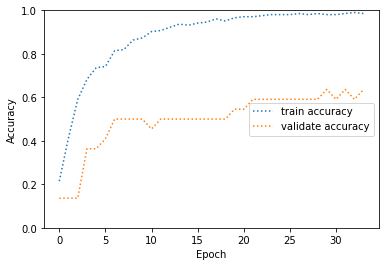

In [20]:
Accuracy = []

for k in range(10):
    tmp = ds
    tmpLbl = dsLbl
    i = k / 10

    test = tmp[int(i * len(ds)):int((i + testPortion) * len(ds))]
    testLabel = tmpLbl[int(i * len(ds)):int((i + testPortion) * len(ds))]

    for _ in range(int(testPortion * len(ds))):
        tmp.pop(int(i * len(ds)))
        tmpLbl.pop(int(i * len(ds)))

    val = tmp[0:int(valPortion * len(ds))]
    valLabel = tmpLbl[0:int(valPortion * len(ds))]

    train = tmp[int(valPortion * len(ds)):]
    trainLabel = tmpLbl[int(valPortion * len(ds)):]


    test = tf.convert_to_tensor(test,  dtype='float64')
    testLabel = tf.one_hot(testLabel, classes)

    train = tf.convert_to_tensor(train,  dtype='float64')
    trainLabel = tf.one_hot(trainLabel, classes)

    val = tf.convert_to_tensor(val,  dtype='float64')
    valLabel = tf.one_hot(valLabel, classes)


    ### CNN

    model = models.Sequential()

    model.add(layers.Conv1D(18, 2, strides=2, activation=tf.nn.relu, input_shape=(sampleLen, features)))
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    model.add(layers.Conv1D(36, 2, strides=2, activation=tf.nn.relu))
    model.add(layers.MaxPooling1D(pool_size=2, strides=1))

    model.add(layers.Conv1D(72, 2, strides=2, activation=tf.nn.relu))
    model.add(layers.MaxPooling1D(pool_size=2, strides=1))

    model.add(layers.Conv1D(144, 2, strides=2, activation=tf.nn.relu))
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))

    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(classes, activation='softmax'))


    model.compile(optimizer=optimizers.Adam(learning_rate=learnRate), metrics=['accuracy'],
                loss=losses.CategoricalCrossentropy(from_logits=False))

    earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

    history = model.fit(train, trainLabel, batch_size=10, epochs=epoch, 
                        shuffle=True, validation_data=(val, valLabel), 
                        callbacks=[earlyStop])


    plt.plot(history.history['accuracy'], '-.', label='train accuracy')
    plt.plot(history.history['val_accuracy'], '-.', label='validate accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

    # print(f"Accuracy: {model.evaluate(test, testLabel)[1] * 100:.2f}%")
    Accuracy.append(model.evaluate(test, testLabel)[1] * 100)
    plt.savefig(r"C:\Users\A R H\Desktop\CNN_" + str(i) + ".png")
    plt.show()


    ### LSTM
    model = models.Sequential()

    model.add(layers.LSTM(32, return_sequences=True, input_shape=(sampleLen, features)))

    model.add(layers.Flatten())

    model.add(layers.Dense(classes, activation='softmax'))


    model.compile(optimizer=optimizers.Adam(learning_rate=learnRate), 
                    metrics=['accuracy'],
                    loss=losses.CategoricalCrossentropy(from_logits=False))

    earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

    history = model.fit(train, trainLabel, batch_size=10, epochs=epoch, 
                        shuffle=True, validation_data=(val, valLabel), 
                        callbacks=[earlyStop])


    plt.plot(history.history['accuracy'], ':', label='train accuracy')
    plt.plot(history.history['val_accuracy'], ':', label='validate accuracy')
    # plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
    # plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='right')

    # print(f"Accuracy: {model.evaluate(test, testLabel)[1] * 100:.2f}%")
    Accuracy.append(model.evaluate(test, testLabel)[1] * 100)
    plt.savefig(r"C:\Users\A R H\Desktop\RNN_" + str(i) + ".png")
    plt.show()

In [21]:
Accuracy

[15.625,
 26.5625,
 81.03448152542114,
 82.75862336158752,
 75.0,
 78.84615659713745,
 93.6170220375061,
 93.6170220375061,
 83.33333134651184,
 71.42857313156128,
 76.31579041481018,
 60.52631735801697,
 74.28571581840515,
 80.0000011920929,
 83.87096524238586,
 74.19354915618896,
 96.42857313156128,
 100.0,
 100.0,
 100.0]